In [1]:
import torch
import torch.nn as nn

In [2]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Test Input - Float to Int Quant

In [3]:
A = torch.rand(20)*6-3
A

tensor([-0.5485, -2.0048,  2.0016,  1.1713, -2.3020,  2.7250, -1.7213, -0.2578,
         1.3539, -1.8108, -1.6988,  1.4849, -2.4349, -2.5632, -2.9215,  2.8782,
         2.2793, -1.7268,  2.9433,  2.1054])

In [6]:
intA = torch.round(A/3*127, decimals=0)

In [8]:
quantA = intA/127*3

In [9]:
quantA

tensor([-0.5433, -2.0079,  2.0079,  1.1811, -2.2913,  2.7165, -1.7244, -0.2598,
         1.3465, -1.8189, -1.7008,  1.4882, -2.4331, -2.5748, -2.9291,  2.8819,
         2.2677, -1.7244,  2.9528,  2.1024])

## The Toy Dataset

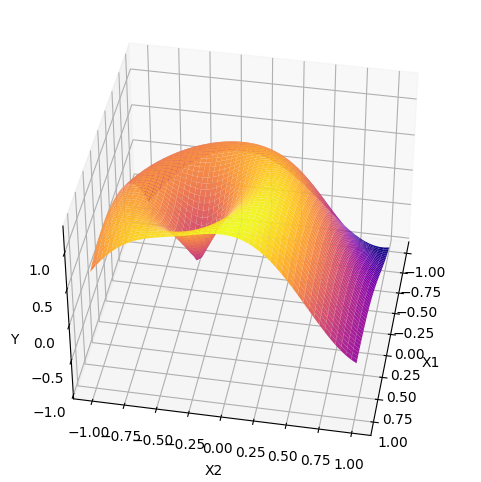

In [10]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1 + (X1+X2)/3

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

########################

%matplotlib inline
ax = plt.figure(figsize=(6,6)).add_subplot(projection='3d')
ax.view_init(elev=40., azim=10)

ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

# plt.savefig("./reg_toy_data.pdf", bbox_inches='tight')
plt.show()

In [20]:
from torch.quantization.observer import MinMaxObserver, MovingAverageMinMaxObserver, HistogramObserver
C, L = 3, 4
normal = torch.distributions.normal.Normal(0,1)
inputs = [normal.sample((C, L)), normal.sample((C, L))]
print(inputs)

[tensor([[-1.5439,  1.0515, -0.6819,  0.3130],
        [-0.8355,  0.5526,  0.0860,  0.6778],
        [ 0.5407,  2.0956,  0.4055, -0.5012]]), tensor([[-1.0811,  0.6645,  0.2154, -0.5982],
        [ 0.3391, -0.6687, -0.2164,  0.4814],
        [-0.2037,  1.2019, -1.1053, -0.2370]])]


In [28]:
observers = [MinMaxObserver(), MovingAverageMinMaxObserver(), HistogramObserver()]
for obs in observers:
    for x in inputs:obs(x) 
    print(obs.__class__.__name__, "\n",obs.calculate_qparams())

MinMaxObserver 
 (tensor([0.0143]), tensor([108], dtype=torch.int32))
MovingAverageMinMaxObserver 
 (tensor([0.0142]), tensor([108], dtype=torch.int32))
HistogramObserver 
 (tensor([0.0143]), tensor([108], dtype=torch.int32))


In [29]:
obs = MovingAverageMinMaxObserver()

In [30]:
obs(x)

tensor([[-1.0811,  0.6645,  0.2154, -0.5982],
        [ 0.3391, -0.6687, -0.2164,  0.4814],
        [-0.2037,  1.2019, -1.1053, -0.2370]])

In [41]:
qx = torch.quantize_per_tensor_dynamic(x, torch.qint8, False)
qx

tensor([[-1.0767,  0.6605,  0.2171, -0.5972],
        [ 0.3348, -0.6695, -0.2171,  0.4795],
        [-0.2081,  1.2034, -1.1038, -0.2352]], size=(3, 4), dtype=torch.qint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.009047844363193886,
       zero_point=-6)

In [44]:
qx.dequantize()

tensor([[-1.0767,  0.6605,  0.2171, -0.5972],
        [ 0.3348, -0.6695, -0.2171,  0.4795],
        [-0.2081,  1.2034, -1.1038, -0.2352]])

#### Train a simple model with Pytorch Quant

In [169]:
class ST_Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        h = 20
        self.w1 = nn.Parameter(torch.randn(2, h))
        self.b1 = nn.Parameter(torch.zeros(h))
        self.w2 = nn.Parameter(torch.randn(h, 1))                
        self.b2 = nn.Parameter(torch.zeros(1))
        self.actf = nn.ELU()
#         self.norm = nn.LayerNorm(h)
        self.norm = nn.BatchNorm1d(h)

        
        self.qw1 = torch.ao.quantization.fake_quantize.FakeQuantize(dtype=torch.qint8)
        self.qx = torch.ao.quantization.fake_quantize.FakeQuantize(dtype=torch.qint8)
        
    def forward(self, x):
#         x = float_to_int8_range(x)
#         t = 0.9
        
        w1, b1, w2, b2 = self.w1, self.b1, self.w2, self.b2
        
#         x = torch.quantize_per_tensor_dynamic(x, torch.qint8, False).dequantize()
#         w1 = torch.quantize_per_tensor_dynamic(w1, torch.qint8, False).dequantize()
        x = self.qx(x)
#         w1 = self.qw1(w1)
        w1 = self.qx(w1)
        
        x = -torch.cdist(x, w1.t())
        x = self.actf(self.norm(x+b1))
        x = x@w2+b2
        return x

In [170]:
model = ST_Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = nn.MSELoss()

In [171]:
model.w1

Parameter containing:
tensor([[ 0.5229, -1.3196, -2.0855,  0.1716, -0.6851,  0.8834, -0.7773,  0.0346,
          1.1111,  0.6357, -1.0118,  1.9420, -1.3298, -1.0688,  0.2869,  0.4284,
         -1.4311, -0.2646,  1.3673, -0.8304],
        [-1.1096, -0.6218,  1.3370, -0.8882,  0.0477, -0.1418, -1.4199,  0.9810,
          0.7888,  0.3150,  0.3906, -0.2293, -1.0952, -1.7117, -0.7828, -0.3336,
         -2.2449, -1.0314,  0.7493, -1.7828]], requires_grad=True)

Epoch: 99, Loss:0.10254711657762527
Epoch: 199, Loss:0.028608014807105064
Epoch: 299, Loss:0.013764016330242157
Epoch: 399, Loss:0.00851433351635933
Epoch: 499, Loss:0.006408844608813524
Epoch: 599, Loss:0.00512270350009203
Epoch: 699, Loss:0.004775212146341801
Epoch: 799, Loss:0.004083435051143169
Epoch: 899, Loss:0.004360914696007967
Epoch: 999, Loss:0.003401342313736677


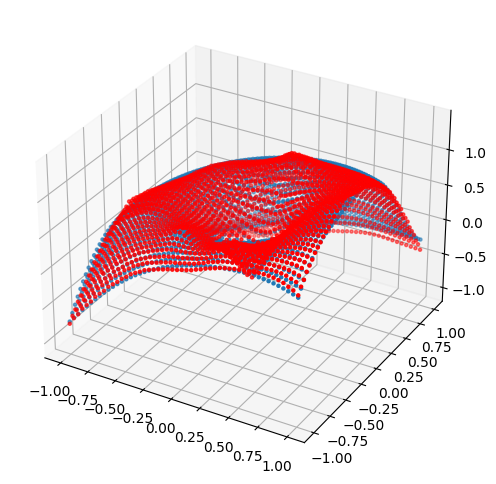

Epoch: 1099, Loss:0.0033436818048357964
Epoch: 1199, Loss:0.0026060487143695354
Epoch: 1299, Loss:0.0022370214574038982
Epoch: 1399, Loss:0.002174693625420332
Epoch: 1499, Loss:0.0018778688972815871
Epoch: 1599, Loss:0.0017229996155947447
Epoch: 1699, Loss:0.0021408512257039547
Epoch: 1799, Loss:0.001334581640549004
Epoch: 1899, Loss:0.0012236341135576367
Epoch: 1999, Loss:0.0014319380279630423


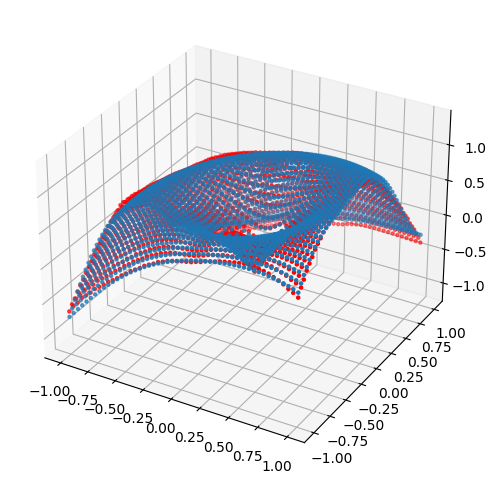

Epoch: 2099, Loss:0.0019980971701443195
Epoch: 2199, Loss:0.00106355722527951
Epoch: 2299, Loss:0.0009662766242399812
Epoch: 2399, Loss:0.0009181268978863955
Epoch: 2499, Loss:0.0009175972663797438
Epoch: 2599, Loss:0.0009500961168669164
Epoch: 2699, Loss:0.0009014866664074361
Epoch: 2799, Loss:0.0007759257568977773
Epoch: 2899, Loss:0.0010413179406896234
Epoch: 2999, Loss:0.0009244594839401543


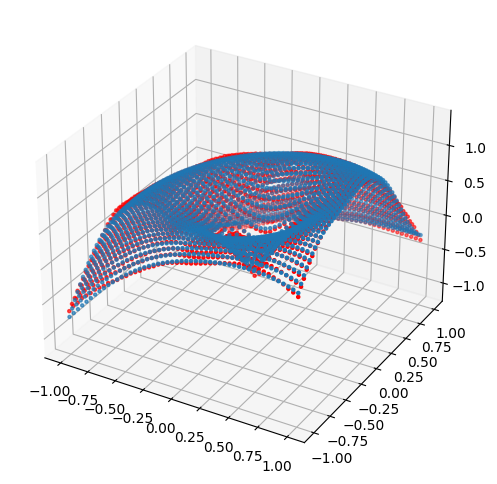

Epoch: 3099, Loss:0.0008309225086122751
Epoch: 3199, Loss:0.0006996473530307412
Epoch: 3299, Loss:0.0006975767901167274
Epoch: 3399, Loss:0.0006535909487865865
Epoch: 3499, Loss:0.0006628681439906359
Epoch: 3599, Loss:0.0006288202712312341
Epoch: 3699, Loss:0.0007362570031546056
Epoch: 3799, Loss:0.0007103544194251299
Epoch: 3899, Loss:0.0008729498949833214
Epoch: 3999, Loss:0.0012954168487340212


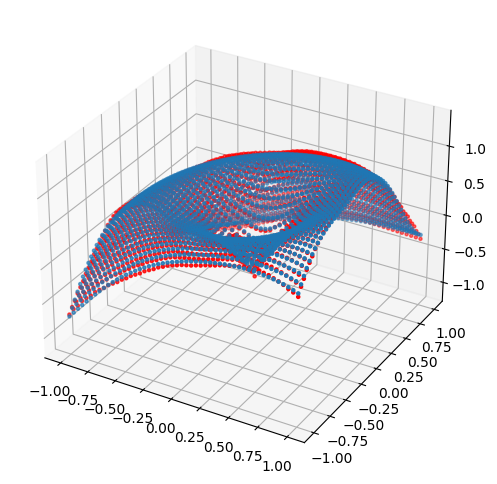

Epoch: 4099, Loss:0.0015564733184874058
Epoch: 4199, Loss:0.0008592219091951847
Epoch: 4299, Loss:0.0007300232537090778
Epoch: 4399, Loss:0.0006551204714924097
Epoch: 4499, Loss:0.001045438228175044
Epoch: 4599, Loss:0.0005633154651150107
Epoch: 4699, Loss:0.0011833219323307276
Epoch: 4799, Loss:0.0009569930844008923
Epoch: 4899, Loss:0.0011669108644127846
Epoch: 4999, Loss:0.0011588617926463485


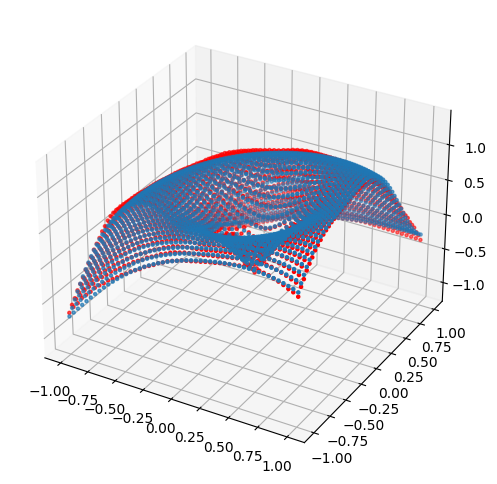

Epoch: 5099, Loss:0.0009245796245522797
Epoch: 5199, Loss:0.000988139770925045
Epoch: 5299, Loss:0.0007474673911929131
Epoch: 5399, Loss:0.0006259811925701797
Epoch: 5499, Loss:0.0007188782910816371
Epoch: 5599, Loss:0.0009138594614341855
Epoch: 5699, Loss:0.0005846788990311325
Epoch: 5799, Loss:0.0009930562227964401
Epoch: 5899, Loss:0.0007347833598032594
Epoch: 5999, Loss:0.0009776310762390494


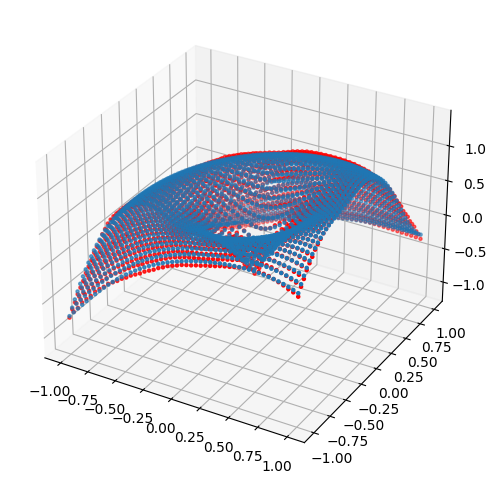

Epoch: 6099, Loss:0.0008805004181340337
Epoch: 6199, Loss:0.0012326579308137298
Epoch: 6299, Loss:0.0011291602859273553
Epoch: 6399, Loss:0.0007460991619154811
Epoch: 6499, Loss:0.0010200674878433347
Epoch: 6599, Loss:0.0007945247925817966
Epoch: 6699, Loss:0.0007030072156339884
Epoch: 6799, Loss:0.0005023654666729271
Epoch: 6899, Loss:0.0008562894654460251
Epoch: 6999, Loss:0.0006992127746343613


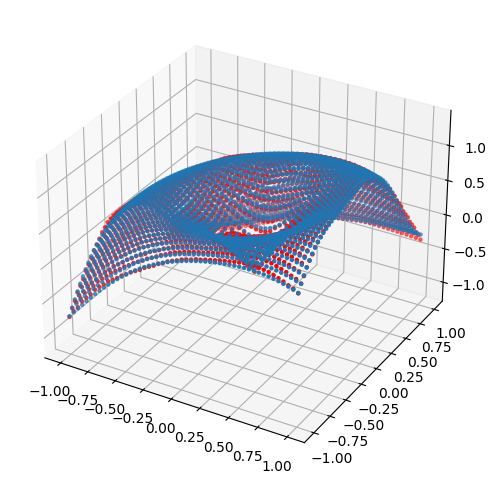

Epoch: 7099, Loss:0.0005790739669464529
Epoch: 7199, Loss:0.0007720104185864329
Epoch: 7299, Loss:0.0006350580370053649
Epoch: 7399, Loss:0.0006597778992727399
Epoch: 7499, Loss:0.0013035426381975412
Epoch: 7599, Loss:0.0009846045868471265
Epoch: 7699, Loss:0.000943907827604562
Epoch: 7799, Loss:0.0005410362500697374
Epoch: 7899, Loss:0.0006186077371239662
Epoch: 7999, Loss:0.000684766098856926


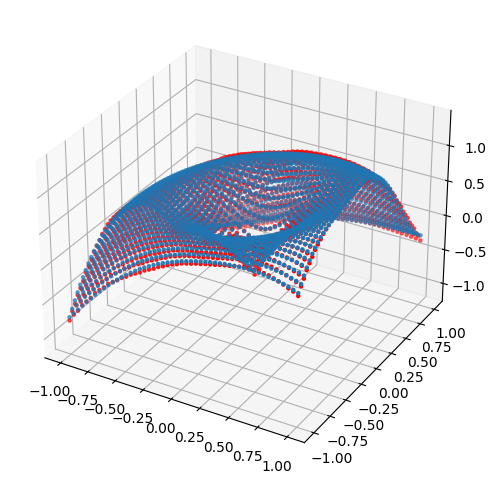

Epoch: 8099, Loss:0.0005552778020501137
Epoch: 8199, Loss:0.001326428260654211
Epoch: 8299, Loss:0.0007316952687688172
Epoch: 8399, Loss:0.0007907403050921857
Epoch: 8499, Loss:0.0007393298437818885
Epoch: 8599, Loss:0.0011475452920421958
Epoch: 8699, Loss:0.0005123066948726773
Epoch: 8799, Loss:0.0010288218036293983
Epoch: 8899, Loss:0.000837951258290559
Epoch: 8999, Loss:0.001021826989017427


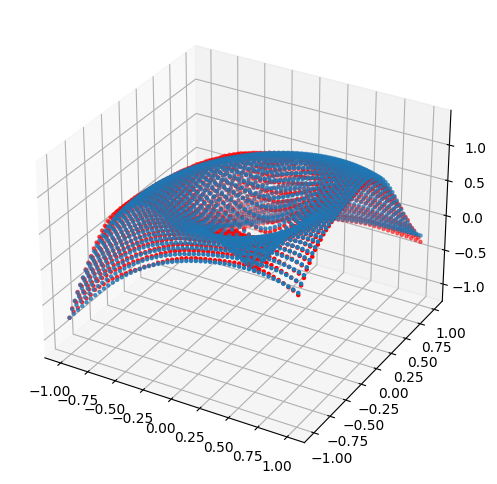

Epoch: 9099, Loss:0.0008812117739580572
Epoch: 9199, Loss:0.0008459226810373366
Epoch: 9299, Loss:0.0011488728923723102
Epoch: 9399, Loss:0.0004544324765447527
Epoch: 9499, Loss:0.0008235012064687908
Epoch: 9599, Loss:0.0006716165225952864
Epoch: 9699, Loss:0.0015358219388872385
Epoch: 9799, Loss:0.0005458766245283186
Epoch: 9899, Loss:0.0005421582609415054
Epoch: 9999, Loss:0.0006549607496708632


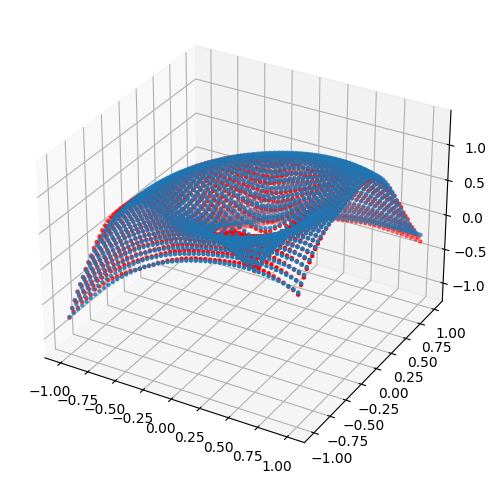

In [172]:
losses = []
for epoch in range(10000):
    yout = model(xx)
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%100 == 0:
        print(f'Epoch: {epoch}, Loss:{float(loss)}')
        losses.append(float(loss))

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot(projection='3d')
        ax.scatter(X1, X2, Y, marker= '.')
        ax.scatter(X1, X2, yout.data.cpu().numpy().reshape(-1), color='r', marker='.')
        plt.show()

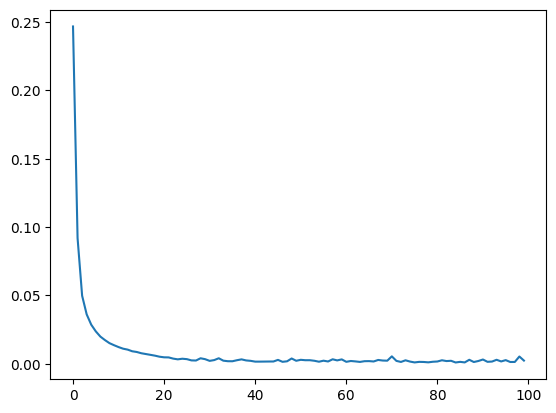

In [148]:
plt.plot(losses)

In [149]:
model.w1

Parameter containing:
tensor([[-0.4512,  0.2212, -0.7510,  0.9219,  1.0990, -0.6458,  1.6124,  1.0227,
          1.6359, -1.0464, -0.9337,  0.3051, -1.7564,  1.6157,  0.1154, -0.8715,
          0.1577,  1.7570,  3.3144,  0.3256],
        [-0.7887,  1.5252,  0.7710,  0.1580,  0.5058,  0.0948, -0.0496, -1.1036,
          0.1883, -1.0797, -1.3488, -0.3470,  0.7467, -2.0551, -0.3262, -0.4518,
         -0.8094, -1.1401,  0.4939,  0.2000]], requires_grad=True)

In [150]:
model.qw1.eval()

FakeQuantize(
  fake_quant_enabled=tensor([1], dtype=torch.uint8), observer_enabled=tensor([1], dtype=torch.uint8), quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([0.0210]), zero_point=tensor([-30], dtype=torch.int32)
  (activation_post_process): MovingAverageMinMaxObserver(min_val=-2.0516552925109863, max_val=3.3124921321868896)
)

In [151]:
model.qw1.calculate_qparams()

(tensor([0.0210]), tensor([-30], dtype=torch.int32))

In [152]:
model.qw1(model.w1)

tensor([[-0.4418,  0.2314, -0.7573,  0.9256,  1.0939, -0.6521,  1.6198,  1.0308,
          1.6408, -1.0518, -0.9256,  0.3155, -1.7460,  1.6198,  0.1052, -0.8625,
          0.1473,  1.7670,  3.3027,  0.3155],
        [-0.7783,  1.5356,  0.7783,  0.1683,  0.5049,  0.1052, -0.0421, -1.0939,
          0.1893, -1.0728, -1.3463, -0.3366,  0.7363, -2.0615, -0.3366, -0.4418,
         -0.7994, -1.1359,  0.4838,  0.2104]],
       grad_fn=<FakeQuantizePerTensorAffineCachemaskTensorQparamsBackward0>)

In [155]:
(model.w1/model.qw1.scale + model.qw1.zero_point).type(torch.int)

tensor([[ -51,  -19,  -65,   13,   22,  -60,   46,   18,   47,  -79,  -74,  -15,
         -113,   46,  -24,  -71,  -22,   53,  127,  -14],
        [ -67,   42,    6,  -22,   -5,  -25,  -32,  -82,  -21,  -81,  -94,  -46,
            5, -127,  -45,  -51,  -68,  -84,   -6,  -20]], dtype=torch.int32)

In [156]:
model.qx

FakeQuantize(
  fake_quant_enabled=tensor([1], dtype=torch.uint8), observer_enabled=tensor([1], dtype=torch.uint8), quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([0.0078]), zero_point=tensor([-1], dtype=torch.int32)
  (activation_post_process): MovingAverageMinMaxObserver(min_val=-1.0, max_val=1.0)
)

In [158]:
1/model.qw1.scale

tensor([47.5374])

In [159]:
model.qw1

FakeQuantize(
  fake_quant_enabled=tensor([1], dtype=torch.uint8), observer_enabled=tensor([1], dtype=torch.uint8), quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([0.0210]), zero_point=tensor([-30], dtype=torch.int32)
  (activation_post_process): MovingAverageMinMaxObserver(min_val=-2.051690101623535, max_val=3.3125112056732178)
)

ST_Net(
  (actf): ELU(alpha=1.0)
  (norm): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
  (qw1): FakeQuantize(
    fake_quant_enabled=tensor([1], dtype=torch.uint8), observer_enabled=tensor([1], dtype=torch.uint8), quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([0.0210]), zero_point=tensor([-30], dtype=torch.int32)
    (activation_post_process): MovingAverageMinMaxObserver(min_val=-2.051690101623535, max_val=3.3125112056732178)
  )
  (qx): FakeQuantize(
    fake_quant_enabled=tensor([1], dtype=torch.uint8), observer_enabled=tensor([1], dtype=torch.uint8), quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([0.0078]), zero_point=tensor([-1], dtype=torch.int32)
    (activation_post_process): MovingAverageMinMaxObserver(min_val=-1.0, max_val=1.0)
  )
)

In [ ]:
### Rough

In [116]:
torch.quantize_per_tensor_dynamic(model.w1, torch.qint8, False).dequantize()

In [87]:
fq = torch.ao.quantization.fake_quantize.FakeQuantize(dtype=torch.qint8)

In [95]:
fq(x).dtype

torch.float32

In [96]:
fq

FakeQuantize(
  fake_quant_enabled=tensor([1], dtype=torch.uint8), observer_enabled=tensor([1], dtype=torch.uint8), quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([0.0090]), zero_point=tensor([-6], dtype=torch.int32)
  (activation_post_process): MovingAverageMinMaxObserver(min_val=-1.1052707433700562, max_val=1.2019295692443848)
)

In [93]:
fq.calculate_qparams()

torch.qint8

## Scaling Parameter